In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rgm import *

In [3]:
file_name = "2.npz"
path = "../../../data/walker/run/"

res = onp.load(path + file_name)

In [4]:
res["observation"].shape

(501, 3, 64, 64)

In [5]:
!pip install -q mediapy


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


walker

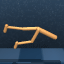

In [6]:
import mediapy

ims = [onp.transpose(res["observation"][i], (1, 2, 0)) for i in range(res["observation"].shape[0])]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"walker": ims}, width=320, height=320, fps=20, codec='gif')

In [32]:
observations = onp.transpose(res["observation"], (0, 2, 3, 1))
actions = res["action"]

In [33]:
num_frames = 128
offset = 64

observations = observations[offset : offset + num_frames]
actions = actions[offset : offset + num_frames]

In [15]:
rgm = RGM()
rgm.fit(observations, actions)

Maximum probability state about factor 0 at time 0: 43
Maximum probability state about factor 0 at time 1: 4
Maximum probability state about factor 0 at time 2: 9
Maximum probability state about factor 0 at time 3: 52
Maximum probability state about factor 0 at time 4: 36
Maximum probability state about factor 0 at time 5: 56
Maximum probability state about factor 0 at time 6: 27
Maximum probability state about factor 0 at time 7: 7
Maximum probability state about factor 0 at time 8: 22
Maximum probability state about factor 0 at time 9: 53
Maximum probability state about factor 0 at time 10: 42
Maximum probability state about factor 0 at time 11: 41
Maximum probability state about factor 0 at time 12: 21
Maximum probability state about factor 0 at time 13: 6
Maximum probability state about factor 0 at time 14: 58
Maximum probability state about factor 0 at time 15: 25
Maximum probability state about factor 0 at time 16: 47
Maximum probability state about factor 0 at time 17: 15
Maximu

In [16]:
qs = rgm.infer_states(observations[:4], actions[:4], None)

In [17]:
print(qs)

[Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]


In [26]:
imgs, u = rgm.reconstruct(qs)
print(u)

[[-1.    1.   -0.25 -0.5  -0.75 -0.25]
 [-1.    1.    1.   -1.   -0.5   0.5 ]
 [ 1.    0.25  0.5  -0.75 -1.    1.  ]
 [ 1.   -1.    1.   -1.    0.    1.  ]]


reconstruction

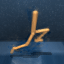

In [27]:
import mediapy

mediapy.show_videos({"reconstruction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")

In [28]:
priors = rgm.infer_empirical_prior(jnp.array([[0]]), qs)

In [34]:
qs_next = rgm.infer_states(observations[4:8], actions[4:8], priors)

In [35]:
print(qs_next)

[Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],      dtype=float32)]


[[ 1.   -1.    1.   -1.    1.    1.  ]
 [ 1.   -0.75  1.   -1.    1.    0.75]
 [-1.    0.5   0.   -0.75  1.    0.75]
 [-1.    0.5   0.75  1.    0.25  1.  ]]


prediction

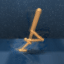

In [36]:
imgs, u = rgm.reconstruct(qs_next)
print(u)
mediapy.show_videos({"prediction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")